In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import   InceptionV3
from tensorflow.keras.applications import   InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import cv2
import pathlib
import matplotlib as mpl

In [2]:
img_width = 225
img_height = 255
batch_size = 64
color = 3
dataset_folder = "Date Fruit"
classes_name = ['Aseel', 'Fasli Toto', 'Gajar', 'Kupro']

In [3]:
def Blurring(image):
    image = cv2.medianBlur(image,5)
    return image
def image_generator(dataset_folder):
    datagen = ImageDataGenerator( rescale=1/255, validation_split=0.2,
                               vertical_flip=True ,
                               horizontal_flip=True,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               rotation_range = 5, 
                               shear_range = 0.02,zoom_range = 0.02,
                               preprocessing_function = Blurring)
    train_generator = datagen.flow_from_directory(
      dataset_folder,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      subset='training')
    validation_generator = datagen.flow_from_directory(
      dataset_folder,
      target_size=(img_height, img_width),
      batch_size= batch_size,
      shuffle=False,
      class_mode='categorical',
      subset='validation')
    return [train_generator, validation_generator]

In [4]:
[training_dataset, validation_dataset] = image_generator(dataset_folder)

Found 2404 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [5]:
# Get class indices and classes
class_indices = training_dataset.class_indices
classes = training_dataset.classes
# Count number of images per class
class_counts = {class_name: np.sum(classes == class_index) for class_name, class_index in class_indices.items()}
print ('****************train************************************')
# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

****************train************************************
Class 'Aseel': 396 images
Class 'Fasli Toto': 312 images
Class 'Gajar': 1048 images
Class 'Kupro': 648 images


In [6]:
# Get class indices and classes
class_indices = validation_dataset.class_indices
classes = validation_dataset.classes
# Count number of images per class
class_counts = {class_name: np.sum(classes == class_index) for class_name, class_index in class_indices.items()}
print ('****************test************************************')
# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

****************test************************************
Class 'Aseel': 98 images
Class 'Fasli Toto': 78 images
Class 'Gajar': 262 images
Class 'Kupro': 162 images


In [7]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.layers import Input, Concatenate, Dense, Activation,Flatten,Dropout
model_1 = load_model('modelInception.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model')
model_2 = load_model('modelInceptionResNetV2.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_mode2')
models = [model_1, model_2]

model_1.trainable = False
model_2.trainable = False

# Create the input layer
model_input = Input(shape=(255, 225,3))

# Pass the input through the base models
model_1_output = model_1 (model_input)
model_2_output = model_2 (model_input)

# Concatenate the outputs of the base models
combined_output = Concatenate()([model_1_output, model_2_output])

# Add fully connected layers
x = Flatten()(combined_output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(18, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(classes_name), activation='softmax')(x)

# Create the stacking ensemble model
stacking_model = Model(inputs=model_input, outputs=output_layer)


In [8]:
me = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

In [9]:
base_learning_rate = 0.01
stacking_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=me)

In [10]:
call_1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
callbacks = [call_1]

In [11]:
epochs=50
historyENSEMBLING=stacking_model.fit(
training_dataset,
  epochs=epochs,
  callbacks = callbacks,
  batch_size = batch_size
)


Epoch 1/50

38/38 [==============================] - 317s 8s/step - loss: 0.7547 - tp: 1705.0000 - fp: 67.0000 - tn: 7145.0000 - fn: 699.0000 - accuracy: 0.9203 - precision: 0.9622 - recall: 0.7092 - auc: 0.9762
Epoch 2/50
38/38 [==============================] - 339s 9s/step - loss: 0.4406 - tp: 2284.0000 - fp: 87.0000 - tn: 7125.0000 - fn: 120.0000 - accuracy: 0.9785 - precision: 0.9633 - recall: 0.9501 - auc: 0.9943
Epoch 3/50
38/38 [==============================] - 368s 10s/step - loss: 0.4281 - tp: 2292.0000 - fp: 86.0000 - tn: 7126.0000 - fn: 112.0000 - accuracy: 0.9794 - precision: 0.9638 - recall: 0.9534 - auc: 0.9951
Epoch 4/50
38/38 [==============================] - 354s 9s/step - loss: 0.4244 - tp: 2304.0000 - fp: 82.0000 - tn: 7130.0000 - fn: 100.0000 - accuracy: 0.9811 - precision: 0.9656 - recall: 0.9584 - auc: 0.9955
Epoch 5/50
38/38 [==============================] - 359s 9s/step - loss: 0.4006 - tp: 2327.0000 - fp: 63.0000 - tn: 7149.0000 - fn: 77.0000 - accuracy: 0.

In [12]:
def drawing(p1, p2, p3, p4):
  a = p1[0]
  b = p2[0]
  c = p3[0]
  d = p4[0]
  plt.rcParams["figure.figsize"] = (20,4)
  mpl.style.use('seaborn')
  plt.plot(a,'blue', label=p1[1])
  plt.plot(b,'orange', label=p2[1])
  plt.plot(c,'red', label=p3[1])
  plt.plot(d,'green', label=p4[1])
  plt.legend()

C:\Users\Elite\AppData\Local\Temp\ipykernel_18660\354503818.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


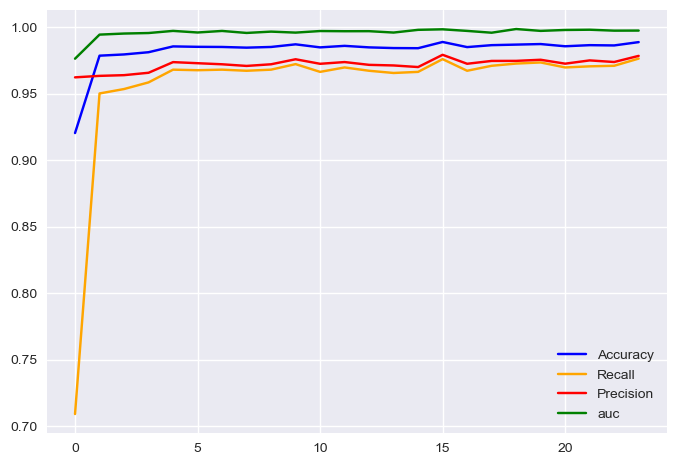

In [13]:
drawing(
    [historyENSEMBLING.history['accuracy'], 'Accuracy'],
    [historyENSEMBLING.history['recall'], 'Recall'],
    [historyENSEMBLING.history['precision'], 'Precision'],
    [historyENSEMBLING.history['auc'], 'auc']
)

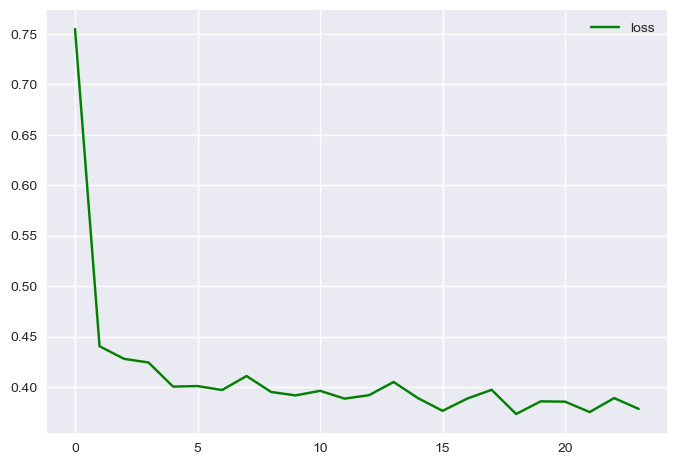

In [14]:
plt.plot(historyENSEMBLING.history['loss'],'green', label="loss")
plt.legend()

In [15]:
stacking_model.evaluate(validation_dataset,batch_size = validation_dataset.batch_size ,steps = validation_dataset.n // validation_dataset.batch_size)

9/9 [==============================] - 93s 9s/step - loss: 0.4095 - tp: 567.0000 - fp: 9.0000 - tn: 1719.0000 - fn: 9.0000 - accuracy: 0.9922 - precision: 0.9844 - recall: 0.9844 - auc: 0.9955


[0.4095447361469269,
 567.0,
 9.0,
 1719.0,
 9.0,
 0.9921875,
 0.984375,
 0.984375,
 0.9955205917358398]

In [16]:
validation_dataset.reset()

In [17]:
Y_pred =stacking_model.predict(validation_dataset,  workers=1)

10/10 [==============================] - 91s 8s/step


In [18]:
y_pred = np.argmax(Y_pred ,  axis = 1)

In [19]:
res = tf.math.confusion_matrix(y_pred,validation_dataset.classes).numpy()
confusion_matrix = pd.DataFrame(res,
                     index = classes_name,
                     columns = classes_name)
confusion_matrix

Aseel  Fasli Toto  Gajar  Kupro
Aseel          96           0      0      0
Fasli Toto      1          73      0      0
Gajar           1           5    259      0
Kupro           0           0      3    162

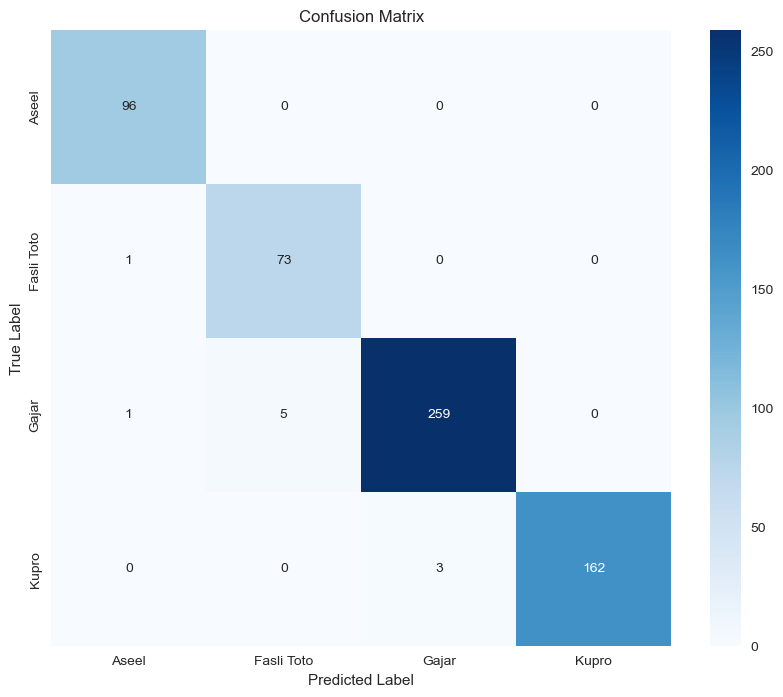

In [20]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
classifi_report = classification_report(validation_dataset.classes, y_pred,target_names = classes_name)
print(classifi_report)

              precision    recall  f1-score   support

       Aseel       1.00      0.98      0.99        98
  Fasli Toto       0.99      0.94      0.96        78
       Gajar       0.98      0.99      0.98       262
       Kupro       0.98      1.00      0.99       162

    accuracy                           0.98       600
   macro avg       0.99      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



2/2 [==============================] - 18s 5s/step


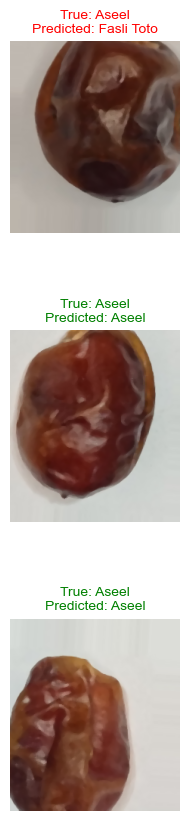

2/2 [==============================] - 10s 5s/step


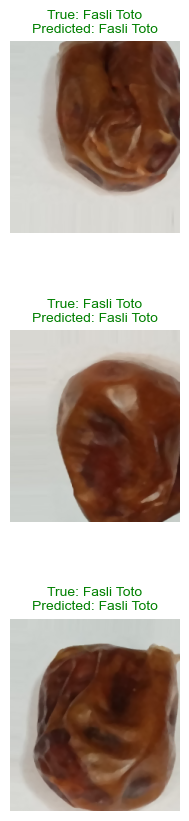

2/2 [==============================] - 10s 5s/step


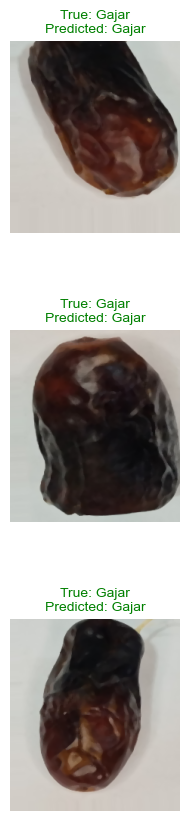

2/2 [==============================] - 9s 4s/step


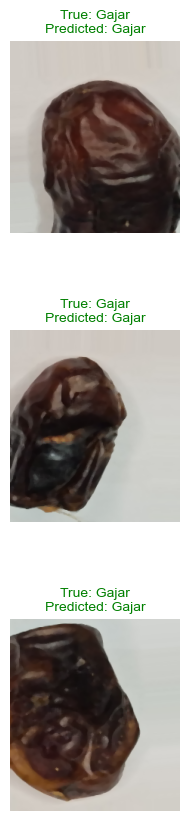

2/2 [==============================] - 10s 5s/step


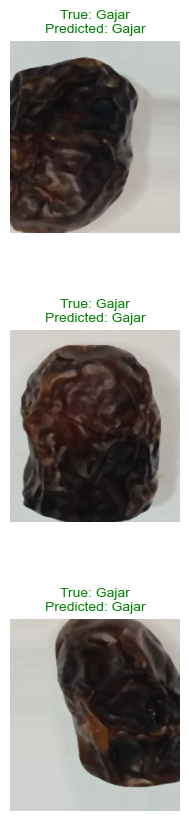

2/2 [==============================] - 9s 4s/step


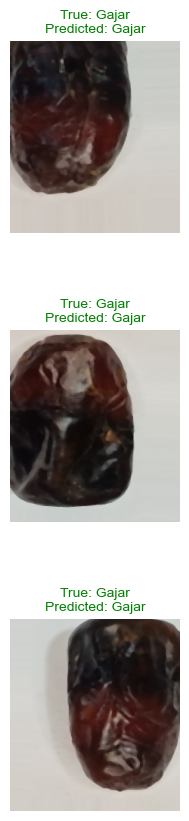

2/2 [==============================] - 9s 4s/step


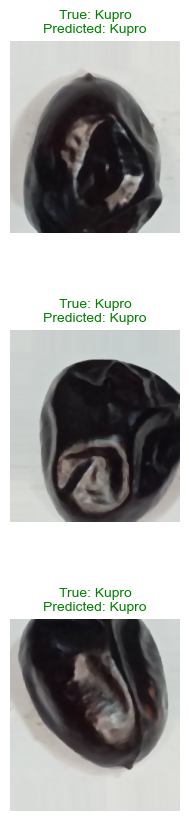

2/2 [==============================] - 8s 4s/step


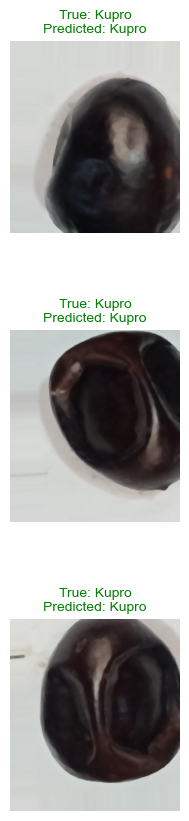

2/2 [==============================] - 10s 5s/step


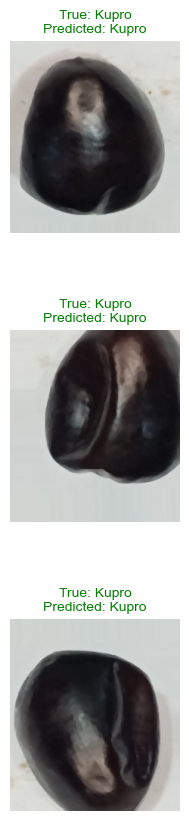

1/1 [==============================] - 12s 12s/step


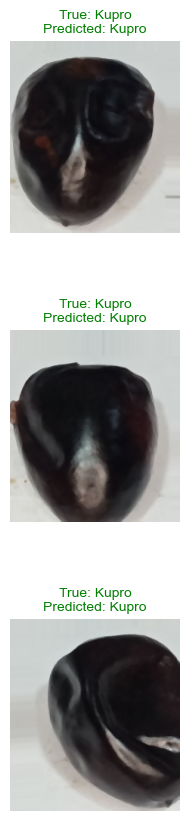

In [22]:
for i in range(len(validation_dataset)):
    # Get a batch of images and true labels
    images, true_labels = validation_dataset[i]
    
    # Predict labels for the batch
    predicted_labels = stacking_model.predict(images)
    predicted_classes = np.argmax(predicted_labels, axis=1)
    
    # Plot images with true and predicted labels
    plt.figure(figsize=(15, 10))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
    for j in range(len(images)):
        # Calculate subplot index within valid range
        subplot_index = j % 3+ 1
        plt.subplot(3, 1, subplot_index)
        
        # Inverse preprocessing (scaling)
        img = images[j]  # No need to undo the preprocessing
        
        # Reverse the normalization
        #img = (img + 1) * 127.5
        #img = np.clip(img, 0, 255).astype(np.uint8)  # Ensure pixel values are in valid range
        
        plt.imshow(img)
        
        # Set title with true and predicted labels
        true_label = classes_name[np.argmax(true_labels[j])]
        predicted_label = classes_name[predicted_classes[j]]
        title = f'True: {true_label}\nPredicted: {predicted_label}'  # Separate lines for better readability
        
        # Set border color based on prediction correctness
        border_color = 'green' if true_label == predicted_label else 'red'
        plt.title(title, color=border_color, fontsize=10)  # Adjust font size for better fit
        plt.axis('off')
    plt.show()

2/2 [==============================] - 9s 4s/step


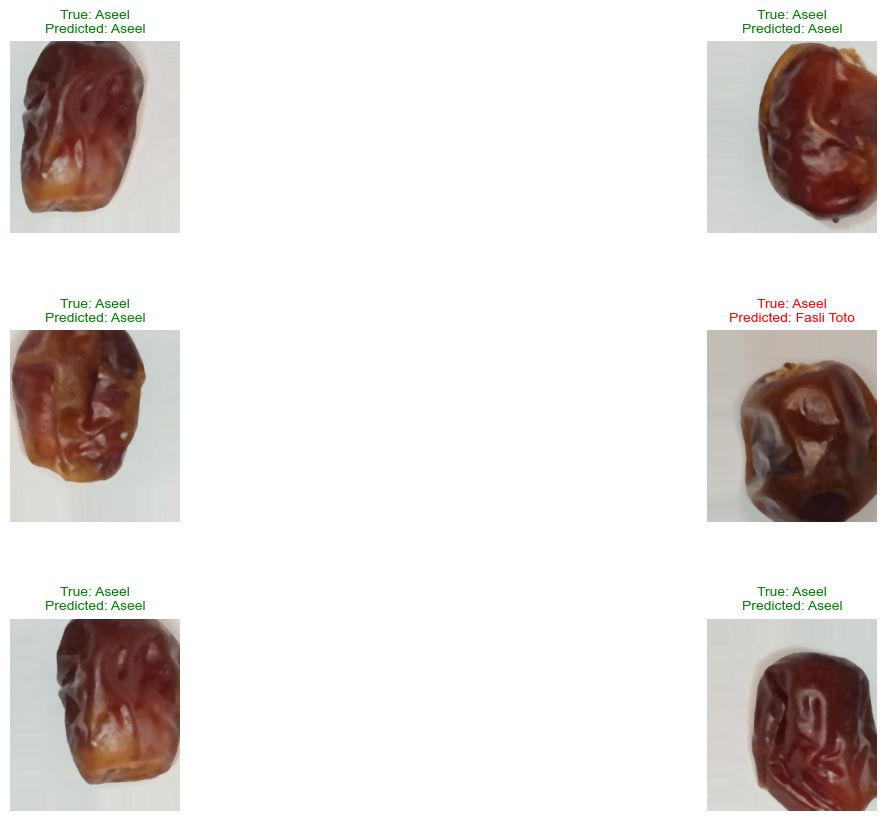

2/2 [==============================] - 9s 4s/step


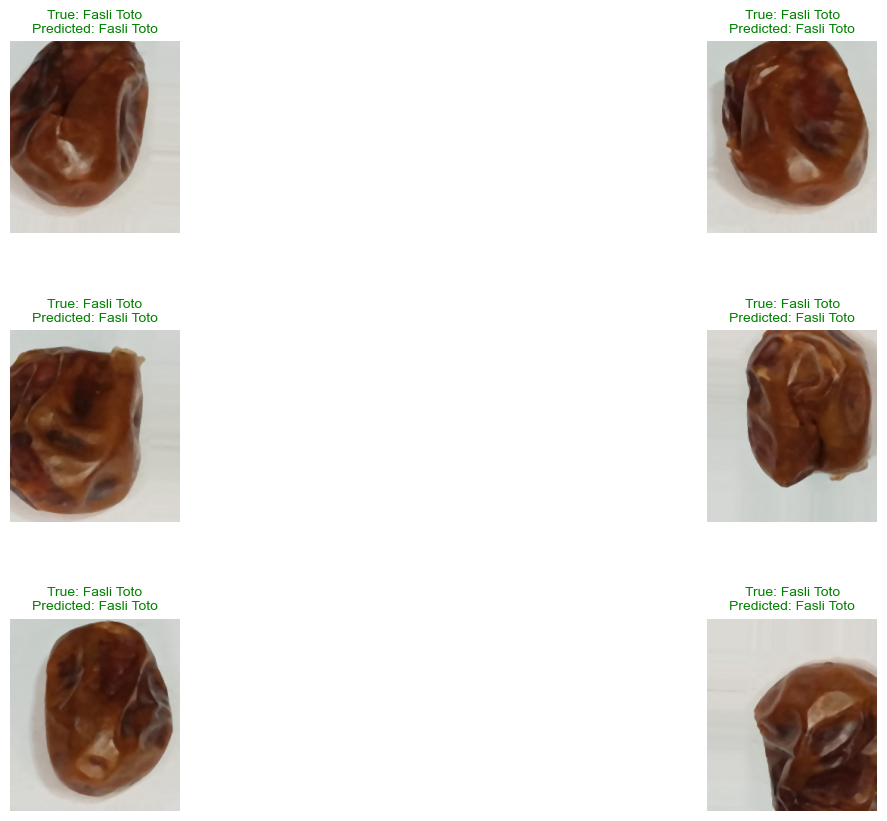

2/2 [==============================] - 9s 4s/step


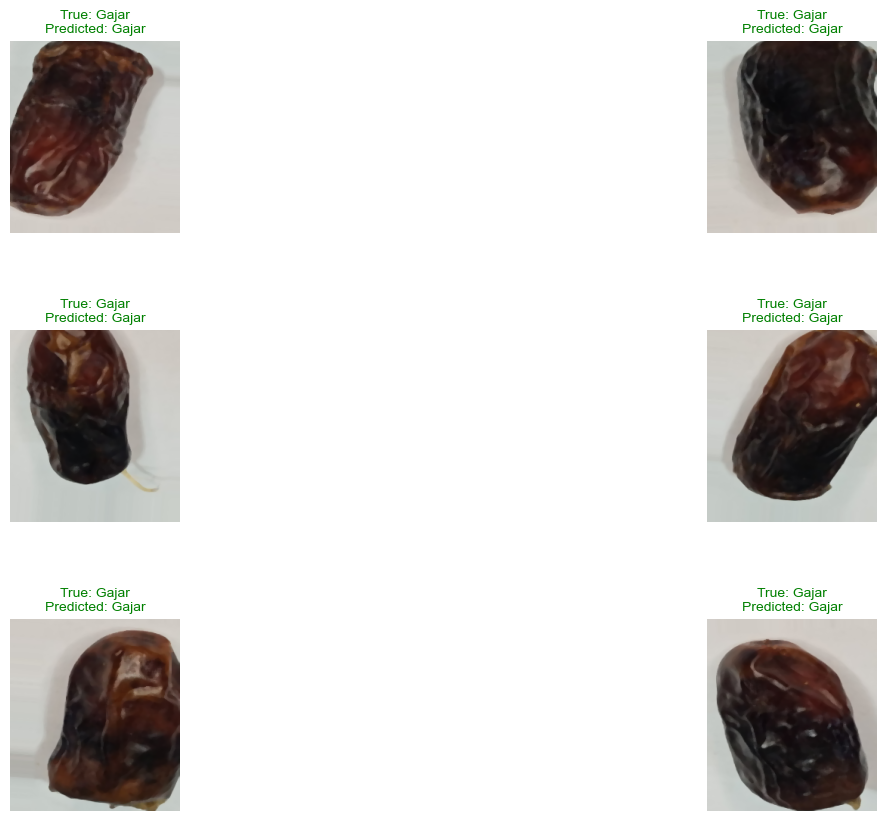

2/2 [==============================] - 9s 5s/step


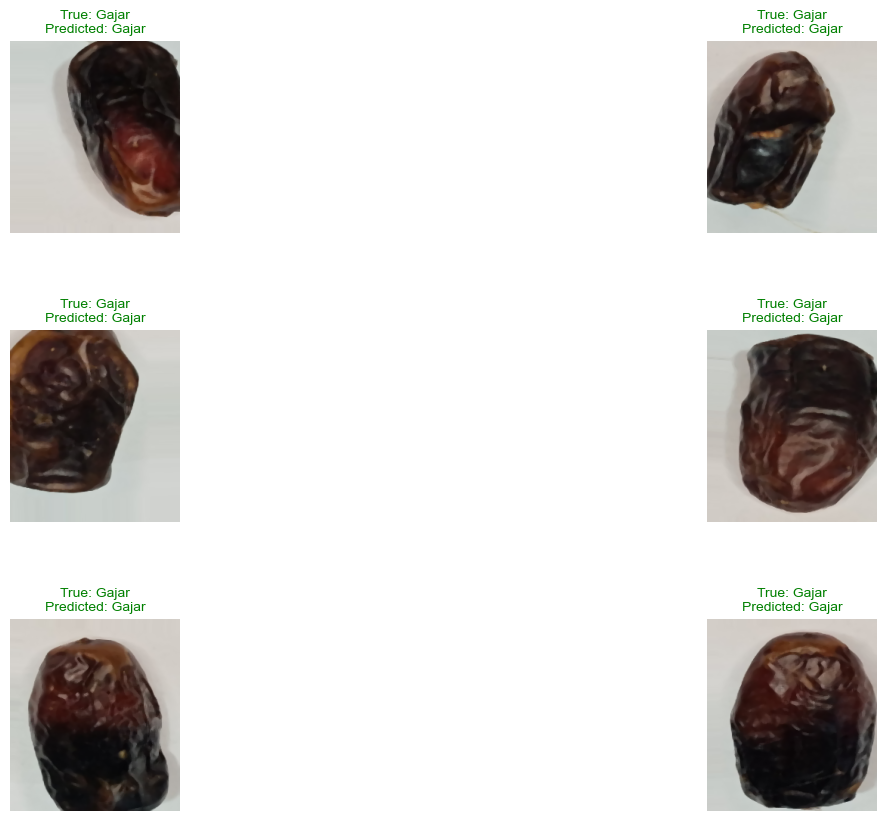

2/2 [==============================] - 9s 4s/step


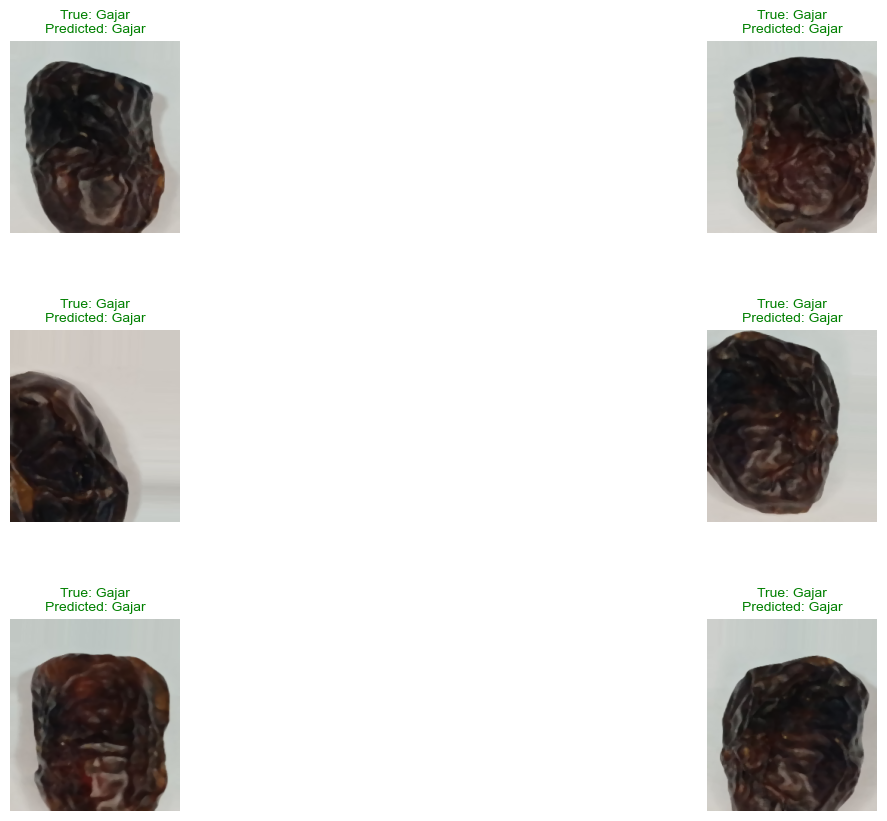

2/2 [==============================] - 9s 4s/step


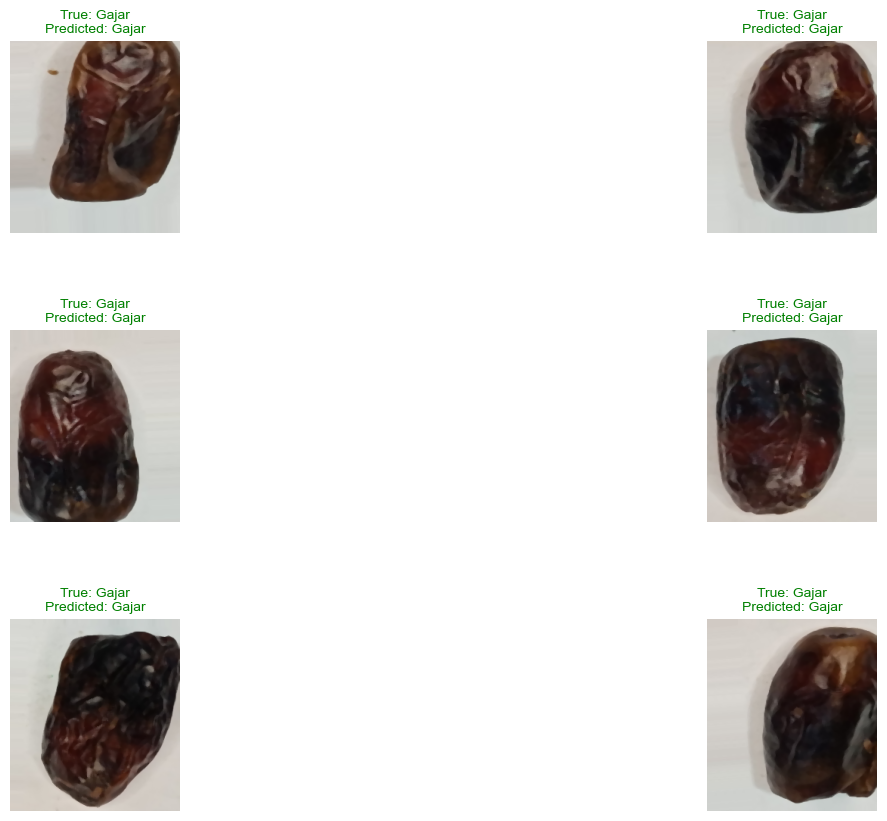

2/2 [==============================] - 10s 4s/step


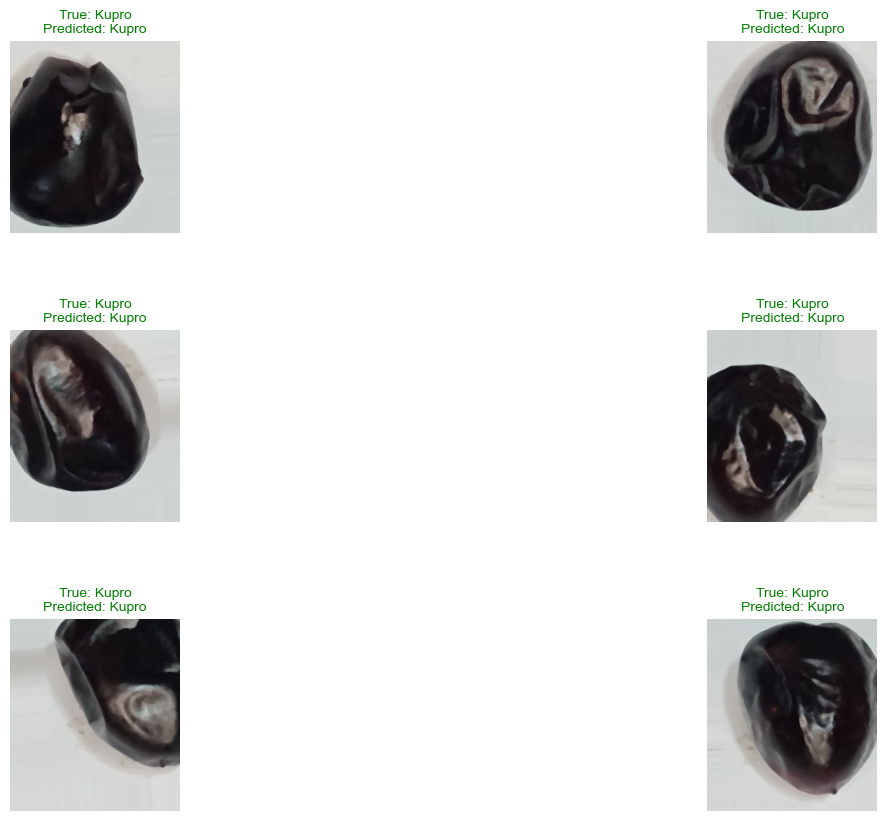

2/2 [==============================] - 9s 4s/step


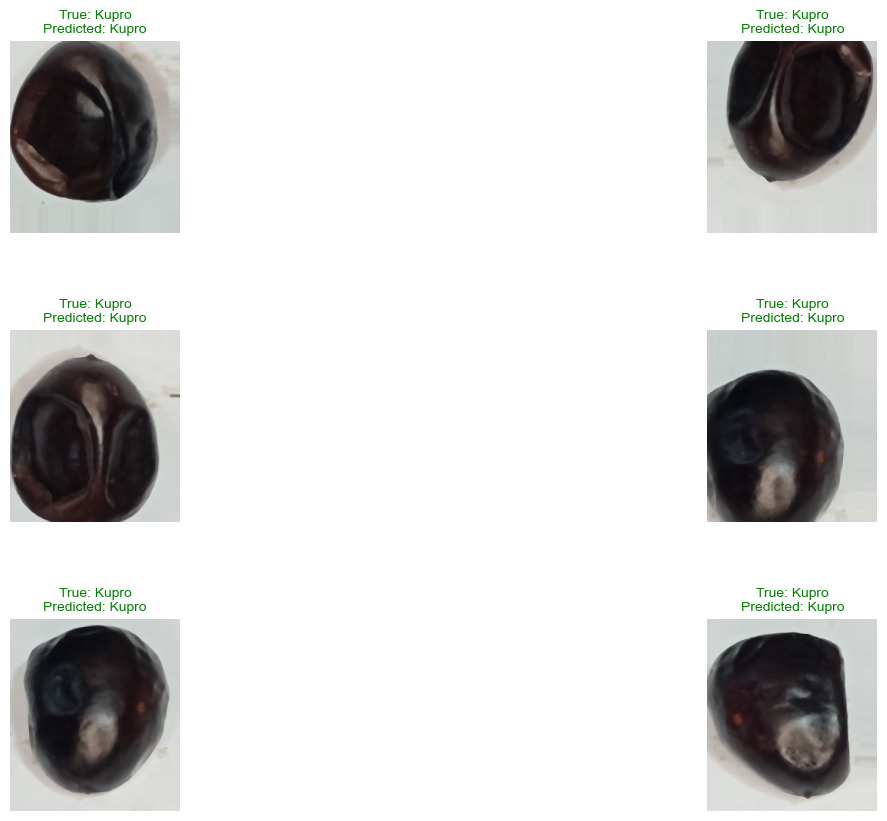

2/2 [==============================] - 9s 5s/step


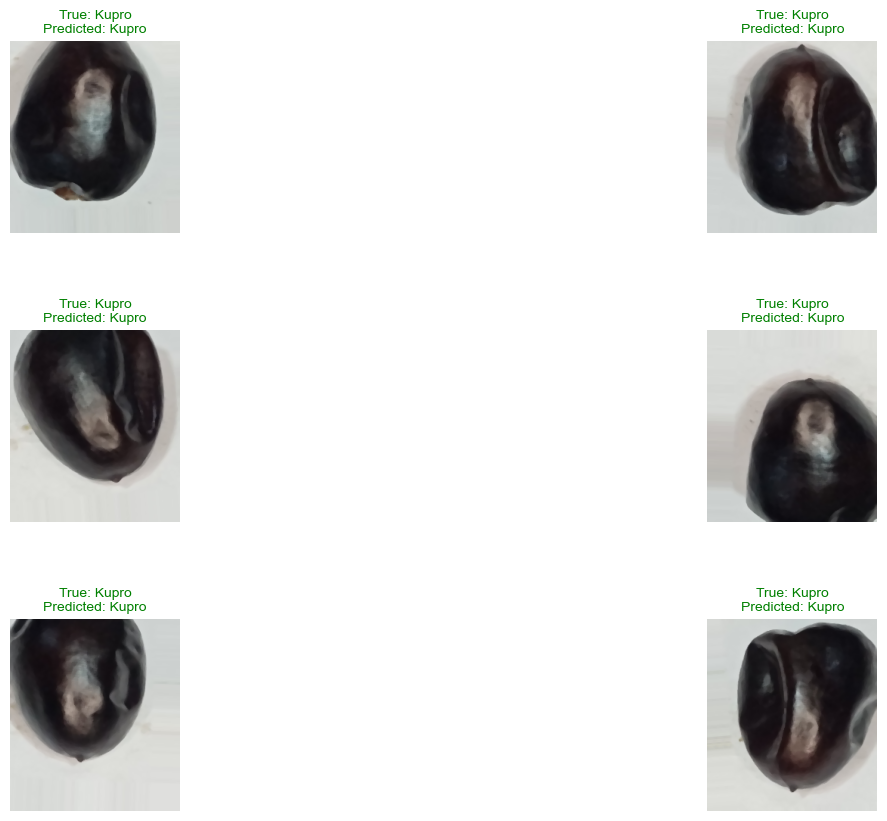

1/1 [==============================] - 3s 3s/step


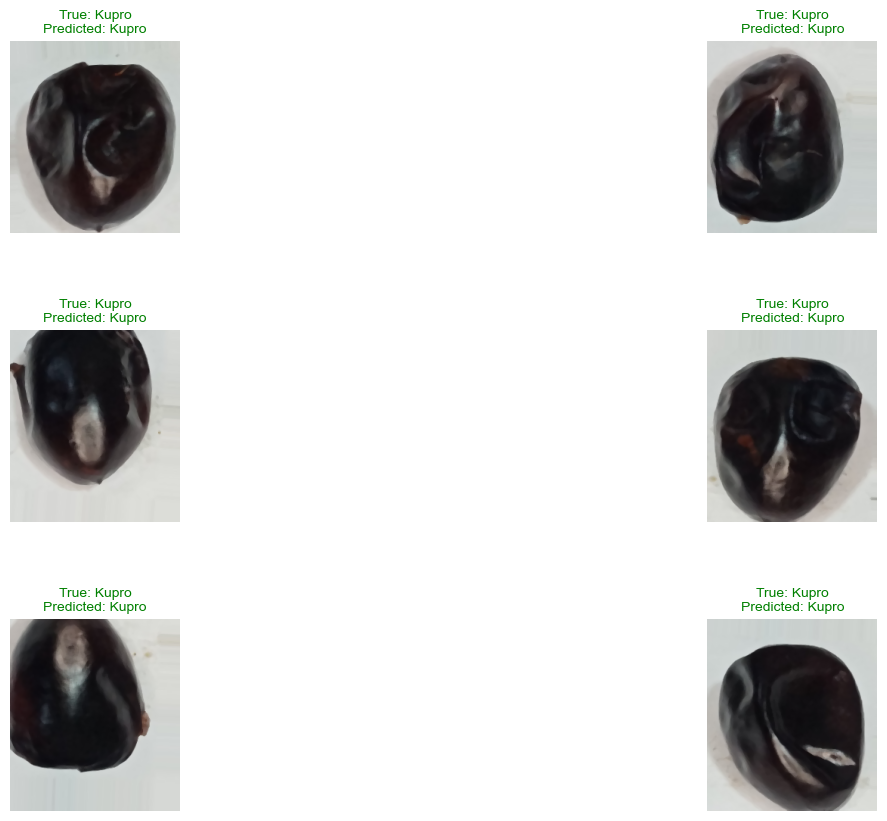

In [23]:

for i in range(len(validation_dataset)):
    # Get a batch of images and true labels
    images, true_labels = validation_dataset[i]
    
    # Predict labels for the batch
    predicted_labels = stacking_model.predict(images)
    predicted_classes = np.argmax(predicted_labels, axis=1)
    
    # Plot images with true and predicted labels
    plt.figure(figsize=(15, 10))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
    for j in range(len(images)):
        # Calculate subplot index within valid range
        subplot_index = j % 6 + 1
        plt.subplot(3, 2, subplot_index)
        
        # Inverse preprocessing (scaling)
        img = images[j]  # No need to undo the preprocessing
        
        # Reverse the normalization
        #img = (img + 1) * 127.5
        #img = np.clip(img, 0, 255).astype(np.uint8)  # Ensure pixel values are in valid range
        
        plt.imshow(img)
        
        # Set title with true and predicted labels
        true_label = classes_name[np.argmax(true_labels[j])]
        predicted_label = classes_name[predicted_classes[j]]
        title = f'True: {true_label}\nPredicted: {predicted_label}'  # Separate lines for better readability
        
        # Set border color based on prediction correctness
        border_color = 'green' if true_label == predicted_label else 'red'
        plt.title(title, color=border_color, fontsize=10)  # Adjust font size for better fit
        plt.axis('off')
    plt.show()